> Read VAE and VQ-VAE before coming to this blog. 

> We will discuss about VQVAE and how autoregressive image modelling works.

> We will also discuss how conditioning is applied to these models. 


VQ-GAN is a family of models which uses auto encoding to reduce the dimensionality of the image and use transformers for the generative aspect of it. 

The model is trained in two stages.
- Train Encoder, quantizer and decoder.
- taking quantizer outputs to train a generative model using autoregressive transformers. 


> The paper also talks about generating megapixel images by using a sling window approch conditioning on previous windows. 

> As usual we will try to make this notebook as informative as possible with minimum dependencies.

## VQGAN
the paper claims that the quality of the reconstructions using VAE detoriates as we increase the receptive field. so we will use a GAN to train the E-Q-D architecture. The model uses LPIPS loss instead of L2 loss, also adds a patch based discrimintor along with commitement and codebook loss (discussed in vqvae).

In [1]:
import torch
import os 
import torchvision
import numpy as np 
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.style.use("bmh")
%matplotlib inline

In [2]:
# Load MNIST data and resize it to 64x64
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('data/', train=True, download=True,
                                transform=torchvision.transforms.Compose([
                                    torchvision.transforms.Pad(2),
                                    torchvision.transforms.ToTensor()
                                ])),
    batch_size=64, shuffle=True)

val_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('data/', train=False, download=True,
                                transform=torchvision.transforms.Compose([
                                    torchvision.transforms.Pad(2),
                                    torchvision.transforms.ToTensor()
                                ])),
    batch_size=64, shuffle=False)

len(train_loader), len(val_loader)

(938, 157)

In [3]:
imgs, labels = next(iter(val_loader))
imgs.shape, labels.shape

(torch.Size([64, 1, 32, 32]), torch.Size([64]))

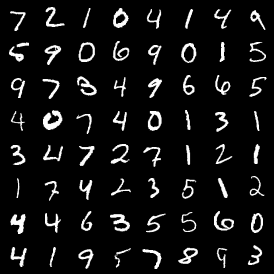

In [4]:
torchvision.transforms.ToPILImage()(torchvision.utils.make_grid(imgs, nrow=8))

> we will use model from VQVAE.

> we will train for 30 epochs with very small learning rate. 

In [5]:
import torch.nn as nn
import torch.nn.functional as F
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            #32x32 -> 16x16
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            #16x16 -> 8x8
            nn.Conv2d(32, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            #8x8 -> 4x4
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
    def forward(self, x):
        x = self.encoder(x)
        return x 
    

class VectorQuantisation(nn.Module):
    def __init__(self, e_dim=256, n_e=1024, beta=0.25):
        super().__init__()
        self.e_dim = e_dim
        self.beta = beta
        self.n_e = n_e 
        self.embedding = nn.Embedding(self.n_e, self.e_dim)
        self.embedding.weight.data.uniform_(-1.0 / self.n_e, 1.0 / self.n_e)
        
    def forward(self, z):
        z = z.permute(0, 2, 3, 1).contiguous()
        z_flattened = z.view(-1, self.e_dim)
        dist = torch.sum(z_flattened**2, dim=1, keepdim=True) + \
            torch.sum(self.embedding.weight**2, dim=1) - \
            2 * torch.matmul(z_flattened, self.embedding.weight.t())
        
        min_encoding_indices = torch.argmin(dist, dim=1).unsqueeze(1)
        min_encodings = torch.zeros(min_encoding_indices.shape[0], self.n_e).to(z)
        min_encodings.scatter_(1, min_encoding_indices, 1)
        z_q = torch.matmul(min_encodings, self.embedding.weight).view(z.shape)

        #calculate the loss
        loss = torch.mean((z_q.detach()-z)**2) + self.beta * \
            torch.mean((z_q - z.detach()) ** 2)
        
        z_q = z + (z_q - z).detach()
        z_q = z_q.permute(0, 3, 1, 2).contiguous()
        return z_q, min_encoding_indices, loss
    

class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.ReLU(),
            #4x4 -> 8x8
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            #8x8 -> 16x16
            nn.ConvTranspose2d(128, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            #32x32 -> 32x32            
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid(),
        )
    def forward(self, z):
        z = self.decoder(z)
        return z

class VQGAN(nn.Module):
    def __init__(self, device='cpu'):
        super().__init__()
        self.encoder = Encoder()
        self.vq = VectorQuantisation()
        self.decoder = Decoder()
        self.device = device

    def forward(self, x, loss_cal=True):
        ze = self.encoder(x)
        z_q, min_encoding_indices, loss = self.vq(ze)
        x_out = self.decoder(z_q)
        if loss_cal:
            reconstruction_loss = F.mse_loss(x_out, x)
            return x_out, min_encoding_indices, loss, reconstruction_loss
        else:
            return x_out, min_encoding_indices, loss
    
    def generate(self, idx):
        z_q = self.vq.embedding(idx)
        #z_q = z_q.view(z_q.shape[0], -1, z_q.shape[-1])
        z_q = z_q.view(z_q.shape[0], 4, 4, self.vq.e_dim)
        z_q = z_q.permute(0, 3, 1, 2).contiguous()
        x_out = self.decoder(z_q)
        return x_out

vqgan = VQGAN()
vqgan.to("mps")
print("model loaded")

model loaded


In [6]:
params = 0
for param in vqgan.parameters():
    params += param.numel()
params


1186273

In [7]:
x = torch.randint(0, 1024, (64, 16)).to("mps")
x_out = vqgan.generate(x)
x_out.shape

torch.Size([64, 1, 32, 32])

## GAN 
In GANs, we have a generator and a discriminator. The discriminator needs to distinguish between the real and fake samples. 

We update the discriminator weights using binary cross entropy loss where real samples should be classified as 1 and fake samples as 0. The generator (encoder and decoder) is updated using a generator loss obtained by trying to fool the discriminator into classifying generated images as real (1).

Discriminator loss: $$ \mathcal{L}_D = -\mathbb{E}_{x \sim p_{data}}[\log D(x)] - \mathbb{E}_{z \sim p_z}[\log(1 - D(G(z)))] $$

Generator loss: $$ \mathcal{L}_G = -\mathbb{E}_{z \sim p_z}[\log D(G(z))] $$


The equations show the standard GAN loss functions where:
- The discriminator tries to maximize the probability of correctly classifying both real and fake samples
- The generator tries to minimize the probability of the discriminator correctly identifying its outputs as fake

> The following things needs to be implemented to train a VQGAN
- discrimintor 
- GAN loss 
- lpips 
- commitment and codebook loss 
- $\lambda$ - adaptive weight. 


## Final losses
- the generator loss is defined as  genloss + adaptive_weight * (rec loss + lpips_loss + commitment loss + code book loss)
- the discriminator loss is just the binary cross entropy lass as seen above. 


## Discriminator 
In the original paper they implemented Patch based discrimintor obtained from pix2pix paper. we will implement a variant of it here. the original paper tried to generate mega pixel size images and hence patched inputs before sending it to the network. Here we don't need it as our images are already very small in size.

In [8]:
def _conv(input_nc, ndf, ks, stride, pad, norm=True):
    conv = torch.nn.Conv2d(input_nc, ndf, kernel_size=ks, stride=stride, padding=pad)
    act = torch.nn.LeakyReLU(0.2, True)
    out = [conv, act]
    if norm: out.append(torch.nn.BatchNorm2d(ndf))
    return torch.nn.Sequential(*out)

class Disc(torch.nn.Module):
    def __init__(self, input_nc=3, ndf=64):
        super(Disc, self).__init__()
        self.layer1 = _conv(input_nc, ndf, 4, 2, 1, norm=False)
        self.layer2 = _conv(ndf, ndf*2, 4, 2, 1)
        self.layer3 = _conv(ndf*2, ndf*2, 4, 2, 1)
        self.layer4 = _conv(ndf*2, ndf*4, 4, 1, 1)
        self.final = torch.nn.Conv2d(ndf*4, 1, kernel_size=4, padding=1)
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.final(x)
        return x 

In [9]:
disc = Disc(1, 32)
disc(imgs).shape

torch.Size([64, 1, 2, 2])

In [10]:
params = 0
for param in disc.parameters():
    params+=param.numel()
params

232737

## LPIPS and GAN loss implementation 

> for LPIPS we will use [lpips package](https://github.com/richzhang/PerceptualSimilarity/tree/master) directly. 

> we will use MSELoss as defined in LSGAN paper.

In [11]:
import lpips
class PerceptionLoss(torch.nn.Module):
    def __init__(self):
        super(PerceptionLoss, self).__init__()
        self.lpips = lpips.LPIPS(net="vgg")

    def forward(self, generated, target):
        return self.lpips(generated, target).mean()


class GANLoss(torch.nn.Module):
    """
    GAN loss
    """

    def __init__(self, use_lsgan=True, target_real_label=1.0, target_fake_label=0.0):
        super(GANLoss, self).__init__()
        self.register_buffer("real_label", torch.tensor(target_real_label))
        self.register_buffer("fake_label", torch.tensor(target_fake_label))
        if use_lsgan:
            self.loss = torch.nn.MSELoss()
        else:
            self.loss = torch.nn.BCELoss()

    def get_target_tensor(self, input, target_is_real):
        if target_is_real:
            target_tensor = self.real_label
        else:
            target_tensor = self.fake_label
        return target_tensor.expand_as(input)

    def forward(self, input, target_is_real):
        target_tensor = self.get_target_tensor(input, target_is_real)
        return self.loss(input, target_tensor)
    

    def generator_loss(self, generated):
        return self.forward(generated, True)

    def discriminator_loss(self, generated, real):
        real_loss = self.forward(real, True)
        fake_loss = self.forward(generated, False)
        return (real_loss + fake_loss) / 2
    
    

In [12]:
ze = vqgan.encoder(imgs.to("mps"))
z_q, min_encoding_indices, loss = vqgan.vq(ze)
z_q.shape, min_encoding_indices.shape, loss

(torch.Size([64, 256, 4, 4]),
 torch.Size([1024, 1]),
 tensor(0.6255, device='mps:0', grad_fn=<AddBackward0>))

## Auto-regressive transformer. 

> we will use a simple transformer inspired from nanoGPT. There is a detailed tutorial by karapthy on youtube about transformers and the casual nature of training it for next token prediction. 

> The network takes 16 tokens, with a vocab size of 1024.

In [13]:
class MLP(nn.Module):

    def __init__(self, n_embd, bias=True, dropout=0.1):
        super().__init__()
        self.c_fc    = nn.Linear(n_embd, 4 * n_embd, bias=bias)
        self.gelu    = nn.GELU()
        self.c_proj  = nn.Linear(4 * n_embd, n_embd, bias=bias)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x
    
class LayerNorm(nn.Module):
    """ LayerNorm but with an optional bias. PyTorch doesn't support simply bias=False """

    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None

    def forward(self, input):
        return F.layer_norm(input, self.weight.shape, self.weight, self.bias, 1e-5)

In [14]:
class CausalSelfAttention(nn.Module):

    def __init__(self, n_embd, n_head, bias=True, dropout=0.1):
        super().__init__()
        assert n_embd % n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(n_embd, 3 * n_embd, bias=bias)
        # output projection
        self.c_proj = nn.Linear(n_embd, n_embd, bias=bias)
        # regularization
        self.attn_dropout = nn.Dropout(dropout)
        self.resid_dropout = nn.Dropout(dropout)
        self.n_head = n_head
        self.n_embd = n_embd
        self.dropout = dropout
        
    def forward(self, x, is_causal=True):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        q, k, v  = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        y = torch.nn.functional.scaled_dot_product_attention(q, k, v, attn_mask=None, dropout_p=self.dropout if self.training else 0, is_causal=True)
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side
        # output projection
        y = self.resid_dropout(self.c_proj(y))
        return y
    
class Block(nn.Module):

    def __init__(self, n_embd, n_head, bias=True, mlp_dropout=0.1, attn_dropout=0.1):
        super().__init__()
        self.ln_1 = LayerNorm(n_embd, bias)
        self.attn = CausalSelfAttention(n_embd, n_head, bias, attn_dropout)
        self.ln_2 = LayerNorm(n_embd, bias)
        self.mlp = MLP(n_embd, bias, mlp_dropout)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x
    
class GPT(nn.Module):

    def __init__(self, vocab_size, block_size, n_embd, n_head, n_layer, bias=True, dropout=0.1):
        super().__init__()
        self.n_embd = n_embd
        self.n_head = n_head
        self.n_layer = n_layer
        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(vocab_size, n_embd),
            wpe = nn.Embedding(block_size, n_embd),
            drop = nn.Dropout(dropout),
            h = nn.ModuleList([Block(n_embd, n_head, bias,  dropout, dropout) for _ in range(n_layer)]),
            ln_f = LayerNorm(n_embd, bias)
        ))
        self.lm_head = nn.Linear(n_embd, vocab_size, bias=False)
    
    def forward(self, idx, targets=None):
        B, T = idx.shape
        pos = torch.arange(0, T, dtype=torch.long, device=idx.device)
        pos_emb = self.transformer.wpe(pos)
        tok_emb = self.transformer.wte(idx)
        x = self.transformer.drop(tok_emb + pos_emb)
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)
        logits = self.lm_head(x)
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
        else:
            # inference-time mini-optimization: only forward the lm_head on the very last position
            logits = self.lm_head(x[:, [-1], :]) # note: using list [-1] to preserve the time dim
            loss = None
        return logits, loss
    

gpt = GPT(vocab_size=512, block_size=16, n_embd=256, n_head=8, n_layer=8, bias=True, dropout=0.1).to("mps")
gpt


GPT(
  (transformer): ModuleDict(
    (wte): Embedding(512, 256)
    (wpe): Embedding(16, 256)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-7): 8 x Block(
        (ln_1): LayerNorm()
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=256, out_features=768, bias=True)
          (c_proj): Linear(in_features=256, out_features=256, bias=True)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm()
        (mlp): MLP(
          (c_fc): Linear(in_features=256, out_features=1024, bias=True)
          (gelu): GELU(approximate='none')
          (c_proj): Linear(in_features=1024, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm()
  )
  (lm_head): Linear(in_features=256, out_features=512, bias=False)
)

In [15]:
idxs = min_encoding_indices.reshape(64, -1)
idxs.shape

torch.Size([64, 16])

In [16]:
go, loss = gpt(idxs, idxs)
go.shape, loss

(torch.Size([64, 16, 512]),
 tensor(4.5652, device='mps:0', grad_fn=<NllLossBackward0>))

## Training code

In [17]:
# I usually clip the graidents while training GAN models to make them stable. 
def clip_gradients(model, clip_value):
    for param in model.parameters():
        if param.grad is not None:
            torch.nn.utils.clip_grad_norm_(param, clip_value)

In [ ]:
epochs = 10
gan_start_epoch = 4
disc = Disc(1, 32).to("mps")
opt_d = torch.optim.AdamW(disc.parameters(), lr=0.0001)
opt_g = torch.optim.AdamW(vqgan.parameters(), lr=0.0001)
gan_loss = GANLoss().to("mps")
perception_loss = PerceptionLoss().to("mps")

iter=0
train_loss = []
val_loss = []
for epoch in range(epochs):
    #train
    disc.train()
    vqgan.train()
    with tqdm(train_loader, total=len(train_loader), desc="Training", leave=False) as pbar:
        for i, (x, _) in enumerate(pbar):

            x = x.to(device='mps')
            x_out, _, qloss = vqgan(x, loss_cal=False)

            # update discrimintor
            #if i % 3 != 0:  # 
            if epoch>=gan_start_epoch:
                opt_d.zero_grad()
                fake = disc(x_out.detach())
                real = disc(x)
                dloss = gan_loss.discriminator_loss(fake, real)
                dloss.backward()
                clip_gradients(disc, 0.05)
                opt_d.step()
            else:
                dloss = torch.tensor(0.0) 

            #update generator 
            opt_g.zero_grad()
            ploss = perception_loss(x_out, x)
            if epoch>gan_start_epoch:
                fake = disc(x_out)
                gloss = gan_loss.generator_loss(fake)
            else:
                gloss = torch.tensor(0.0)
            total_g_loss = gloss+ploss+qloss 
            total_g_loss.backward()
            clip_gradients(vqgan, 0.1)
            opt_g.step()
            
            iter+=1
            pbar.set_postfix(epoch=epoch, gloss=gloss.item(), dloss=dloss.item(), qloss=qloss.item(), ploss=ploss.item())
            train_loss.append([gloss.item(), dloss.item(), qloss.item(), ploss.item()])

    #val
    vqgan.eval()
    disc.eval()
    with tqdm(val_loader, total=len(val_loader), desc="Validating", leave=False) as pbar:
        for i, (x, _) in enumerate(pbar):
            x = x.to(device='mps')
            with torch.no_grad():
                x_out, _, qloss = vqgan(x, loss_cal=False)
                if epoch>=gan_start_epoch:
                    dloss = gan_loss.discriminator_loss(disc(x_out.detach()), disc(x))
                    fake = disc(x_out)
                    gloss = gan_loss.generator_loss(fake)
                else:
                    dloss = torch.tensor(0.0)
                    gloss = torch.tensor(0.0)
                
                ploss = perception_loss(x_out, x)
            val_loss.append([gloss.item(), dloss.item(), qloss.item(), ploss.item()])
            pbar.set_postfix(epoch=epoch, gloss=gloss.item(), dloss=dloss.item(), qloss=qloss.item(), ploss=ploss.item())
            if i == 0:
                gen = x_out.detach().cpu()

    #Generate some images 
    #Generate some images
    generated_imgs = torchvision.transforms.ToPILImage()(torchvision.utils.make_grid(gen, nrow=8))
    if not os.path.exists('generated'):
        os.makedirs('generated')
    generated_imgs.save(f'generated/vqgan_samples_{epoch+1}.png')
    

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/Users/prakashjay/Downloads/genai/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/prakashjay/Downloads/genai/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /Users/prakashjay/Downloads/genai/.venv/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


Training:   1%|          | 7/938 [00:01<02:01,  7.69it/s, dloss=0, epoch=0, gloss=0, ploss=0.697, qloss=0.644]

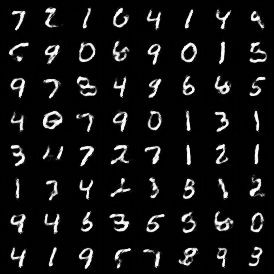

In [ ]:
generated_imgs

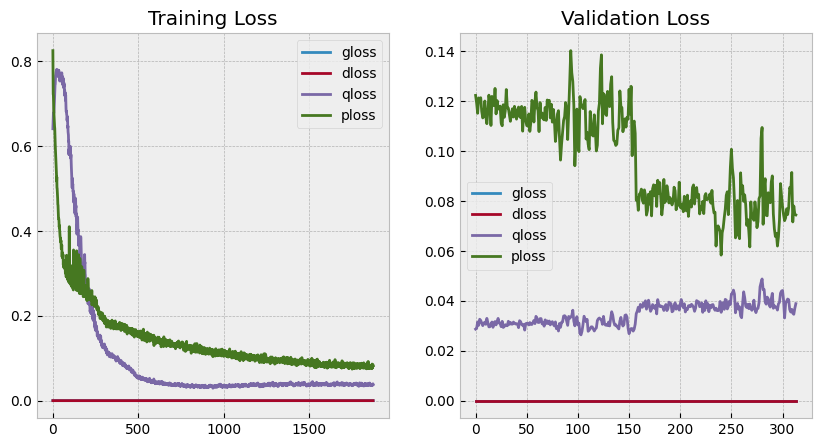

In [ ]:
## plot the training loss
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax.flat[0].plot(train_loss, label=["gloss", "dloss", "qloss", "ploss"])
ax.flat[1].plot(val_loss, label=["gloss", "dloss", "qloss", "ploss"])
ax.flat[0].legend()
ax.flat[1].legend()
ax.flat[0].set_title("Training Loss")
ax.flat[1].set_title("Validation Loss")
plt.show()


> Now lets freeze the vqgan model and train the gpt model.

In [44]:
def generate(model, max_token, batch_size, max_new_tokens, temperature=1.0, device='mps'):
    model.eval()
    tokens = torch.randint(0, max_token, (batch_size, 1)).to(device=device)
    for _ in range(max_new_tokens-1):
        logits = model(tokens)[0][:, -1, :]
        logits = logits / temperature
        probs = F.softmax(logits, dim=-1)
        next_token = torch.multinomial(probs, num_samples=1).detach()
        tokens = torch.cat([tokens, next_token], dim=1)
        if tokens.shape[0] == 16:
            break
    return tokens

In [45]:
tokens = generate(gpt, 1024, 64, 16)
print(tokens.shape)
with torch.no_grad():
    output = vqgan.generate(tokens)
output.shape

torch.Size([64, 16])


torch.Size([64, 1, 32, 32])

In [ ]:
epochs = 10
opt_gpt = torch.optim.AdamW(gpt.parameters(), lr=0.0001)

train_loss = []
for epoch in range(epochs):
    #train
    vqgan.eval()
    gpt.train()
    with tqdm(train_loader, total=len(train_loader), desc="Training", leave=False) as pbar:
        for i, (x, _) in enumerate(pbar):
            x = x.to(device='mps')
            with torch.no_grad():
                ze = vqgan.encoder(x)
                _, min_encoding_indices, _ = vqgan.vq(ze)
            idxs = min_encoding_indices.reshape(64, -1)
            go, loss = gpt(idxs, idxs)
            loss.backward()
            opt_gpt.step()
            pbar.set_postfix(epoch=epoch, loss=loss.item())
            train_loss.append([loss.item()])
    
    #val
    vqgan.eval()
    gpt.eval()
    for i in range(10):
        with torch.no_grad():
            tokens = generate(gpt, 1024, 64, 16)
            output = vqgan.generate(tokens)
        generated_imgs = torchvision.transforms.ToPILImage()(torchvision.utils.make_grid(output, nrow=8))
        if not os.path.exists('generated'):
            os.makedirs('generated')
        generated_imgs.save(f'generated/vqgan_ar_samples_{epoch+1}_{i}.png')
        
        
            

In [ ]:
## plot the training loss
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.flat[0].plot(train_loss, label=["loss"])
ax.flat[0].legend()
ax.flat[0].set_title("Training Loss")
plt.show()


## TODO:
- we need to switch off the discrimintor for the first few epochs as discussed in the paper. 
- Need to add generative aspect using quantized outputs from Encoder. 
- reweighting GAN loss with other losses. 

## Autoregressive transformer
In this section we will implement a simple autoregressive transformer model on top of quantized outputs. 